In [20]:
%%capture
!pip install gymnasium pygame -q
!git clone https://github.com/MattChanTK/gym-maze.git
!cd gym-maze && python3 setup.py install

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import gymnasium as gym

import warnings
warnings.filterwarnings('ignore')

In [21]:
gym.__version__

'1.0.0'

Среда Taxi-v3 представляет собой квадратную сетку, в которой такси должно забрать пассажира в одном месте и высадить его в другом месте. Цель агента — научиться перемещаться по сетке наиболее эффективным способом для выполнения этой задачи.

Состояния: Всего 500 возможных состояний, определяемых позицией такси, местоположением пассажира и пунктом назначения.
Действия: 6 возможных действий:
0: движение на юг
1: движение на север
2: движение на восток
3: движение на запад
4: забрать пассажира
5: высадить пассажира
Награды:
За каждое действие: -1
За попытку незаконной посадки/высадки пассажира: -10
За успешную высадку пассажира: +20

In [22]:
# Создание среды Taxi-v3
env = gym.make("Taxi-v3")

In [23]:
# Получение размеров пространства состояний и действий
state_space_size = env.observation_space.n  # Количество состояний (500)
action_space_size = env.action_space.n      # Количество действий (6)


In [24]:
# Инициализация Q-таблицы нулями
q_table = np.zeros((state_space_size, action_space_size))


In [25]:
print(f"Размерность Q-таблицы: {q_table.shape}")

Размерность Q-таблицы: (500, 6)


**Определение гиперпараметров**

alpha (скорость обучения): Определяет, насколько новые знания будут влиять на существующие знания. Значение от 0 до 1.
gamma (коэффициент дисконтирования): Определяет важность будущих наград. Значение от 0 до 1.
epsilon (ε) для ε-жадной стратегии: Используется для баланса между исследованием и использованием известных знаний.

In [26]:
# Гиперпараметры
alpha = 0.1        # Скорость обучения
gamma = 0.99       # Коэффициент дисконтирования
epsilon = 1.0      # Начальное значение ε для ε-жадной стратегии
max_epsilon = 1.0  # Максимальное значение ε
min_epsilon = 0.01 # Минимальное значение ε
epsilon_decay = 0.9995  # Скорость уменьшения ε
episodes = 10000   # Количество эпизодов для обучения
max_steps_per_episode = 100  # Максимальное количество шагов в эпизоде


**Реализация ε-жадной стратегии**


Для обеспечения баланса между исследованием среды и использованием накопленных знаний мы используем ε-жадную стратегию:

С вероятностью ε: выбираем случайное действие (исследование).
С вероятностью (1 - ε): выбираем действие с наибольшим Q-значением (использование).

In [27]:
# Список для хранения суммарных наград за каждый эпизод
rewards_all_episodes = []


In [28]:
import random

In [29]:
# Цикл обучения
for episode in tqdm(range(episodes)):
    # Сброс среды в начале каждого эпизода
    state, _ = env.reset()####!!!!!!! обязательно
    done = False
    total_rewards = 0

    for step in range(max_steps_per_episode):
        # Принятие действия на основе ε-жадной стратегии
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Случайное действие (исследование)
        else:
            action = np.argmax(q_table[state, :])  # Действие с максимальным Q-значением (использование)

        # Выполнение действия и получение нового состояния и награды
        new_state, reward, done, truncated, info = env.step(action)

        # Обновление Q-таблицы по формуле Q-learning
        q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[new_state, :]) - q_table[state, action])

        # Переход в новое состояние
        state = new_state

        # Суммирование полученной награды
        total_rewards += reward

        # Если эпизод завершен, выходим из цикла
        if done or truncated:
            break

    # Снижение ε после каждого эпизода
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Сохранение суммарной награды за эпизод
    rewards_all_episodes.append(total_rewards)

100%|██████████| 10000/10000 [00:13<00:00, 766.93it/s]


Объяснение шагов цикла обучения:

Инициализация: В начале каждого эпизода мы сбрасываем состояние среды и переменные.

Выбор действия: Используя ε-жадную стратегию, выбираем действие.

Выполнение действия: Совершаем действие в среде и получаем новое состояние и награду.

Обновление Q-таблицы: Используем формулу обновления Q-learning для обновления значений в Q-таблице.

Переход в новое состояние: Обновляем текущее состояние для следующей итерации.

Накопление награды: Суммируем награды, полученные в эпизоде.

Проверка завершения эпизода: Если эпизод завершен, выходим из внутреннего цикла.

Обновление ε: Снижаем значение ε для уменьшения степени исследования по мере обучения.


**Анализ результатов обучения**

Вычисление средней награды за каждую тысячу эпизодов

In [30]:
# Разбиваем награды на группы по 1000 эпизодов
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), episodes / 1000)

count = 1000
print("Средняя награда за каждую тысячу эпизодов:\n")
for r in rewards_per_thousand_episodes:
    print(f"Эпизоды {count - 999}–{count}: средняя награда = {np.mean(r):.2f}")
    count += 1000


Средняя награда за каждую тысячу эпизодов:

Эпизоды 1–1000: средняя награда = -308.08
Эпизоды 1001–2000: средняя награда = -95.00
Эпизоды 2001–3000: средняя награда = -15.10
Эпизоды 3001–4000: средняя награда = -2.83
Эпизоды 4001–5000: средняя награда = 1.92
Эпизоды 5001–6000: средняя награда = 4.15
Эпизоды 6001–7000: средняя награда = 5.99
Эпизоды 7001–8000: средняя награда = 6.75
Эпизоды 8001–9000: средняя награда = 7.27
Эпизоды 9001–10000: средняя награда = 7.40


Вычисление средней награды за последние 100 эпизодов


In [31]:
# Средняя награда за последние 100 эпизодов
last_100_rewards = rewards_all_episodes[-100:]
average_last_100 = np.mean(last_100_rewards)
print(f"\nСредняя награда за последние 100 эпизодов: {average_last_100:.2f}")



Средняя награда за последние 100 эпизодов: 7.88


Построение графика суммарных наград

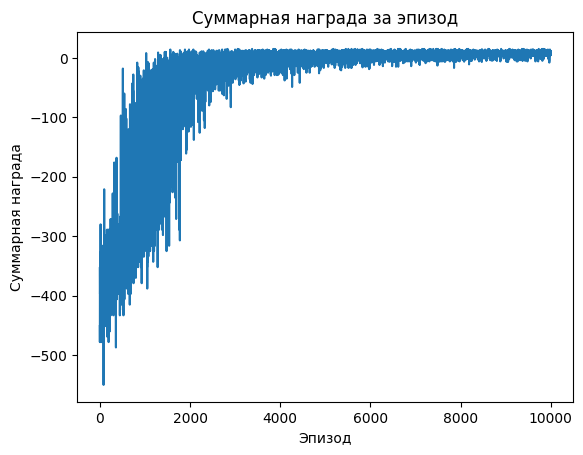

In [32]:
# Построение графика суммарных наград за все эпизоды
plt.plot(rewards_all_episodes)
plt.xlabel('Эпизод')
plt.ylabel('Суммарная награда')
plt.title('Суммарная награда за эпизод')
plt.show()


Построение графика средней награды с окном скользящего среднего

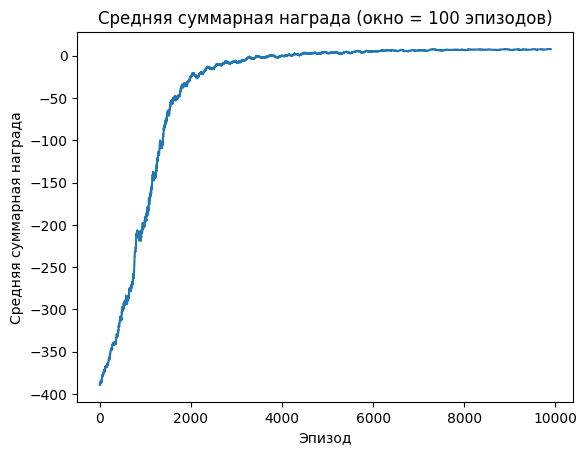

In [33]:
# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(rewards_all_episodes, np.ones(window_size)/window_size, mode='valid')

# Построение графика скользящего среднего
plt.plot(moving_avg)
plt.xlabel('Эпизод')
plt.ylabel('Средняя суммарная награда')
plt.title('Средняя суммарная награда (окно = 100 эпизодов)')
plt.show()


**Оценка обученного агента**

In [34]:
# Устанавливаем ε = 0 для отключения исследования
epsilon = 0.0

# Количество эпизодов для тестирования
test_episodes = 10

for episode in range(test_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0
    steps = 0

    while not done:
        # Выбираем действие с наибольшим Q-значением
        action = np.argmax(q_table[state, :])

        # Выполняем действие и получаем новое состояние и награду
        new_state, reward, done, truncated, info = env.step(action)

        # Переходим в новое состояние
        state = new_state

        # Суммируем награды
        total_rewards += reward
        steps += 1

        if done or truncated:
            print(f"Эпизод {episode+1}: Суммарная награда = {total_rewards}, Шаги = {steps}")
            break

    # Визуализация последнего эпизода
    if episode == test_episodes - 1:
        env.render()


Эпизод 1: Суммарная награда = 8, Шаги = 13
Эпизод 2: Суммарная награда = 9, Шаги = 12
Эпизод 3: Суммарная награда = 7, Шаги = 14
Эпизод 4: Суммарная награда = 9, Шаги = 12
Эпизод 5: Суммарная награда = 7, Шаги = 14
Эпизод 6: Суммарная награда = 10, Шаги = 11
Эпизод 7: Суммарная награда = 7, Шаги = 14
Эпизод 8: Суммарная награда = 7, Шаги = 14
Эпизод 9: Суммарная награда = 8, Шаги = 13
Эпизод 10: Суммарная награда = 7, Шаги = 14


**Сохранение обученного агента**


In [35]:
# Сохранение Q-таблицы в файл
np.save("q_table.npy", q_table)


Загрузка обученного агента

In [38]:
# Загрузка Q-таблицы из файла
q_table_loaded = np.load("q_table.npy")


**Реализация алгоритма Cross-Entropy Method (CEM)**

In [2]:
# Установка необходимых пакетов
!pip install gymnasium pygame --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 7.2 MB/s eta 0:00:00


In [3]:
# Импортируем необходимые библиотеки
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm  # Для отображения прогресса
from IPython.display import clear_output  # Для очистки вывода в Jupyter Notebook
import time  # Для создания задержек в визуализации


Основные шаги алгоритма CEM:

Инициализация политики: Начинаем с некоторой случайной политики.
Генерация траекторий: Используя текущую политику, генерируем множество эпизодов (траекторий).
Оценка траекторий: Оцениваем каждую траекторию по суммарной награде.
Отбор элитных траекторий: Выбираем лучшие траектории на основе некоторого квантиля (например, верхние 10%).
Обновление политики: Обновляем политику на основе действий, совершенных в элитных траекториях.
Повторение: Повторяем процесс до сходимости или достижения максимального количества итераций.

Реализация алгоритма CEM

In [4]:
# Создание среды Taxi-v3
env = gym.make("Taxi-v3")


 Определение класса агента CEM

In [5]:
class CEMAgent:
    """
    Агент на основе алгоритма Cross-Entropy Method.
    """

    def __init__(self, state_space_size, action_space_size):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        # Инициализация политики равномерным распределением
        self.policy = np.ones((state_space_size, action_space_size)) / action_space_size

    def get_action(self, state):
        """
        Выбирает действие на основе текущей политики для заданного состояния.
        """
        action_probabilities = self.policy[state]
        action = np.random.choice(np.arange(self.action_space_size), p=action_probabilities)
        return action

    def update_policy(self, elite_trajectories):
        """
        Обновляет политику на основе элитных траекторий.
        """
        # Обнуление счетчиков
        policy_update = np.zeros((self.state_space_size, self.action_space_size))

        # Суммируем действия из элитных траекторий
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                policy_update[state, action] += 1

        # Нормализация для получения вероятностей
        for state in range(self.state_space_size):
            total = np.sum(policy_update[state])
            if total > 0:
                self.policy[state] = policy_update[state] / total
            else:
                # Если нет данных для состояния, оставляем равномерное распределение
                self.policy[state] = np.ones(self.action_space_size) / self.action_space_size


Инициализация политики: Политика представляется в виде матрицы размером (число_состояний, число_действий), где каждый элемент — вероятность выбора действия в данном состоянии.
Метод get_action: Возвращает действие на основе вероятностей в текущей политике.
Метод update_policy: Обновляет политику на основе элитных траекторий, увеличивая вероятность действий, которые привели к высоким наградам.

**Функции для сбора траекторий и отбора элитных**

In [6]:
def generate_trajectories(env, agent, num_trajectories, max_steps):
    """
    Генерирует заданное количество траекторий с использованием текущей политики агента.
    """
    trajectories = []

    for _ in range(num_trajectories):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}
        state, _ = env.reset()
        done = False

        for _ in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, truncated, info = env.step(action)

            # Сохраняем данные
            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['total_reward'] += reward

            state = next_state

            if done or truncated:
                break

        trajectories.append(trajectory)

    return trajectories

def select_elite_trajectories(trajectories, percentile):
    """
    Отбирает элитные траектории на основе заданного процентиля суммарных наград.
    """
    rewards = [trajectory['total_reward'] for trajectory in trajectories]
    reward_threshold = np.percentile(rewards, percentile)

    elite_trajectories = [trajectory for trajectory in trajectories if trajectory['total_reward'] >= reward_threshold]
    return elite_trajectories


Функция generate_trajectories: Генерирует траектории, используя текущую политику агента.
Функция select_elite_trajectories: Отбирает траектории, суммарная награда которых выше заданного процентиля.

Основной цикл обучения CEM

In [7]:
# Гиперпараметры алгоритма CEM
num_iterations = 100       # Количество итераций обучения
num_trajectories = 500     # Количество траекторий в каждой итерации
max_steps_per_episode = 100  # Максимальное количество шагов в эпизоде
elite_percentile = 90      # Процентиль для отбора элитных траекторий

# Инициализация агента
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
agent = CEMAgent(state_space_size, action_space_size)

# Для хранения средней награды
mean_rewards = []

# Основной цикл обучения
for iteration in tqdm(range(num_iterations)):
    # Генерируем траектории
    trajectories = generate_trajectories(env, agent, num_trajectories, max_steps_per_episode)

    # Отбираем элитные траектории
    elite_trajectories = select_elite_trajectories(trajectories, elite_percentile)

    # Обновляем политику на основе элитных траекторий
    agent.update_policy(elite_trajectories)

    # Сохраняем среднюю награду для визуализации
    mean_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    mean_rewards.append(mean_reward)

    # Выводим информацию
    if (iteration + 1) % 10 == 0:
        print(f"Итерация {iteration + 1}: средняя награда = {mean_reward:.2f}")


 10%|█         | 10/100 [00:28<04:02,  2.70s/it]

Итерация 10: средняя награда = -296.71


 20%|██        | 20/100 [00:55<03:34,  2.69s/it]

Итерация 20: средняя награда = -310.54


 30%|███       | 30/100 [01:20<03:05,  2.65s/it]

Итерация 30: средняя награда = -287.58


 40%|████      | 40/100 [01:45<02:34,  2.58s/it]

Итерация 40: средняя награда = -325.46


 50%|█████     | 50/100 [02:11<02:13,  2.67s/it]

Итерация 50: средняя награда = -315.61


 60%|██████    | 60/100 [02:36<01:43,  2.58s/it]

Итерация 60: средняя награда = -309.60


 70%|███████   | 70/100 [03:01<01:18,  2.63s/it]

Итерация 70: средняя награда = -311.05


 80%|████████  | 80/100 [03:26<00:52,  2.60s/it]

Итерация 80: средняя награда = -305.33


 90%|█████████ | 90/100 [03:52<00:26,  2.66s/it]

Итерация 90: средняя награда = -318.07


100%|██████████| 100/100 [04:17<00:00,  2.58s/it]

Итерация 100: средняя награда = -331.56


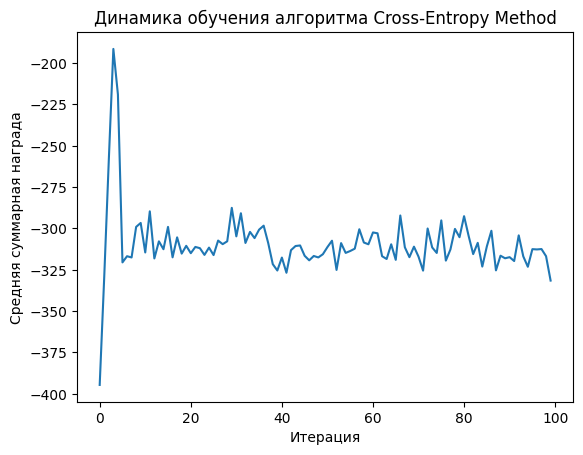

In [8]:
# Построение графика средней награды
plt.plot(mean_rewards)
plt.xlabel('Итерация')
plt.ylabel('Средняя суммарная награда')
plt.title('Динамика обучения алгоритма Cross-Entropy Method')
plt.show()


In [9]:
def plot_learning_curve(iterations, mean_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, mean_rewards, label='Средняя награда')
    plt.xlabel('Итерация')
    plt.ylabel('Средняя суммарная награда')
    plt.title('Кривая обучения агента CEM')
    plt.legend()
    plt.grid(True)
    plt.show()


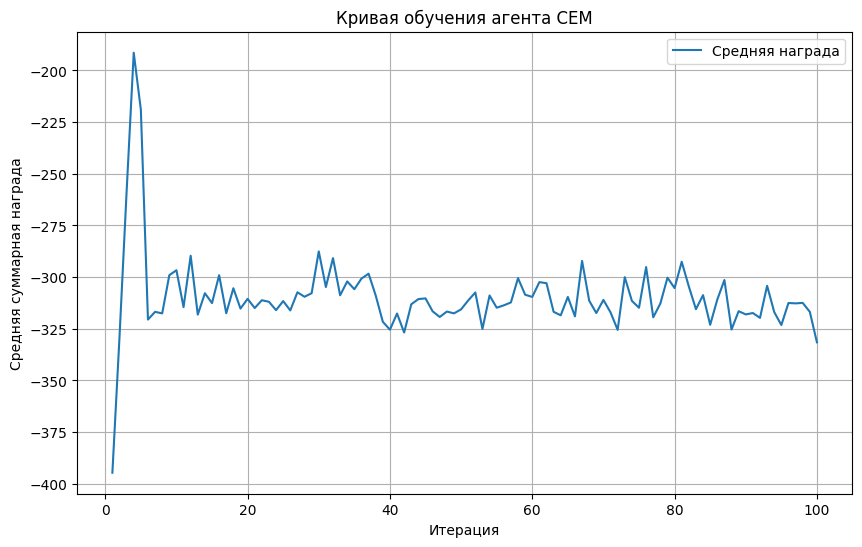

In [10]:
iterations = list(range(1, num_iterations + 1))
plot_learning_curve(iterations, mean_rewards)


In [11]:
# Гиперпараметры алгоритма CEM
num_iterations = 500       # Количество итераций обучения
num_trajectories = 1000     # Количество траекторий в каждой итерации
max_steps_per_episode = 200  # Максимальное количество шагов в эпизоде
elite_percentile = 70      # Процентиль для отбора элитных траекторий

# Инициализация агента
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
agent = CEMAgent(state_space_size, action_space_size)

# Для хранения средней награды
mean_rewards = []

# Основной цикл обучения
for iteration in tqdm(range(num_iterations)):
    # Генерируем траектории
    trajectories = generate_trajectories(env, agent, num_trajectories, max_steps_per_episode)

    # Отбираем элитные траектории
    elite_trajectories = select_elite_trajectories(trajectories, elite_percentile)

    # Обновляем политику на основе элитных траекторий
    agent.update_policy(elite_trajectories)

    # Сохраняем среднюю награду для визуализации
    mean_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    mean_rewards.append(mean_reward)

    # Выводим информацию
    if (iteration + 1) % 10 == 0:
        print(f"Итерация {iteration + 1}: средняя награда = {mean_reward:.2f}")


  2%|▏         | 10/500 [00:54<20:18,  2.49s/it]

Итерация 10: средняя награда = -19.50


  4%|▍         | 20/500 [01:24<27:09,  3.39s/it]

Итерация 20: средняя награда = -169.84


  6%|▌         | 30/500 [01:58<27:11,  3.47s/it]

Итерация 30: средняя награда = -190.77


  8%|▊         | 40/500 [02:33<26:30,  3.46s/it]

Итерация 40: средняя награда = -182.59


 10%|█         | 50/500 [03:09<27:00,  3.60s/it]

Итерация 50: средняя награда = -181.91


 12%|█▏        | 60/500 [03:41<23:26,  3.20s/it]

Итерация 60: средняя награда = -135.67


 14%|█▍        | 70/500 [04:16<24:00,  3.35s/it]

Итерация 70: средняя награда = -178.37


 16%|█▌        | 80/500 [04:51<23:59,  3.43s/it]

Итерация 80: средняя награда = -180.85


 18%|█▊        | 90/500 [05:24<22:35,  3.31s/it]

Итерация 90: средняя награда = -169.74


 20%|██        | 100/500 [05:58<22:12,  3.33s/it]

Итерация 100: средняя награда = -170.28


 22%|██▏       | 110/500 [06:31<21:29,  3.31s/it]

Итерация 110: средняя награда = -167.28


 24%|██▍       | 120/500 [07:06<22:22,  3.53s/it]

Итерация 120: средняя награда = -187.74


 26%|██▌       | 130/500 [07:40<21:50,  3.54s/it]

Итерация 130: средняя награда = -191.23


 28%|██▊       | 140/500 [08:16<21:10,  3.53s/it]

Итерация 140: средняя награда = -178.47


 30%|███       | 150/500 [08:51<20:13,  3.47s/it]

Итерация 150: средняя награда = -168.62


 32%|███▏      | 160/500 [09:25<19:25,  3.43s/it]

Итерация 160: средняя награда = -168.85


 34%|███▍      | 170/500 [09:59<18:38,  3.39s/it]

Итерация 170: средняя награда = -171.70


 36%|███▌      | 180/500 [10:33<18:18,  3.43s/it]

Итерация 180: средняя награда = -193.20


 38%|███▊      | 190/500 [11:08<17:59,  3.48s/it]

Итерация 190: средняя награда = -165.24


 40%|████      | 200/500 [11:43<18:32,  3.71s/it]

Итерация 200: средняя награда = -183.11


 42%|████▏     | 210/500 [12:18<16:46,  3.47s/it]

Итерация 210: средняя награда = -173.29


 44%|████▍     | 220/500 [12:53<16:01,  3.43s/it]

Итерация 220: средняя награда = -169.10


 46%|████▌     | 230/500 [13:27<14:51,  3.30s/it]

Итерация 230: средняя награда = -153.00


 48%|████▊     | 240/500 [14:02<15:14,  3.52s/it]

Итерация 240: средняя награда = -169.21


 50%|█████     | 250/500 [14:36<13:56,  3.35s/it]

Итерация 250: средняя награда = -174.47


 52%|█████▏    | 260/500 [15:10<13:22,  3.34s/it]

Итерация 260: средняя награда = -173.14


 54%|█████▍    | 270/500 [15:45<13:50,  3.61s/it]

Итерация 270: средняя награда = -189.96


 56%|█████▌    | 280/500 [16:19<12:44,  3.48s/it]

Итерация 280: средняя награда = -171.25


 58%|█████▊    | 290/500 [16:54<11:55,  3.41s/it]

Итерация 290: средняя награда = -174.63


 60%|██████    | 300/500 [17:30<11:44,  3.52s/it]

Итерация 300: средняя награда = -176.37


 62%|██████▏   | 310/500 [18:05<11:29,  3.63s/it]

Итерация 310: средняя награда = -196.17


 64%|██████▍   | 320/500 [18:40<10:39,  3.55s/it]

Итерация 320: средняя награда = -172.12


 66%|██████▌   | 330/500 [19:15<09:59,  3.53s/it]

Итерация 330: средняя награда = -187.92


 68%|██████▊   | 340/500 [19:49<08:58,  3.37s/it]

Итерация 340: средняя награда = -171.79


 70%|███████   | 350/500 [20:24<08:47,  3.52s/it]

Итерация 350: средняя награда = -169.06


 72%|███████▏  | 360/500 [21:00<08:28,  3.64s/it]

Итерация 360: средняя награда = -186.31


 74%|███████▍  | 370/500 [21:35<07:40,  3.54s/it]

Итерация 370: средняя награда = -174.08


 76%|███████▌  | 380/500 [22:09<06:45,  3.38s/it]

Итерация 380: средняя награда = -170.85


 78%|███████▊  | 390/500 [22:44<06:27,  3.53s/it]

Итерация 390: средняя награда = -175.40


 80%|████████  | 400/500 [23:20<06:06,  3.66s/it]

Итерация 400: средняя награда = -174.93


 82%|████████▏ | 410/500 [23:56<05:23,  3.59s/it]

Итерация 410: средняя награда = -163.58


 84%|████████▍ | 420/500 [24:30<04:38,  3.48s/it]

Итерация 420: средняя награда = -178.75


 86%|████████▌ | 430/500 [25:05<03:58,  3.41s/it]

Итерация 430: средняя награда = -171.01


 88%|████████▊ | 440/500 [25:40<03:28,  3.47s/it]

Итерация 440: средняя награда = -156.09


 90%|█████████ | 450/500 [26:15<03:01,  3.62s/it]

Итерация 450: средняя награда = -194.87


 92%|█████████▏| 460/500 [26:50<02:18,  3.46s/it]

Итерация 460: средняя награда = -158.33


 94%|█████████▍| 470/500 [27:25<01:43,  3.46s/it]

Итерация 470: средняя награда = -174.54


 96%|█████████▌| 480/500 [28:00<01:09,  3.50s/it]

Итерация 480: средняя награда = -173.25


 98%|█████████▊| 490/500 [28:36<00:36,  3.69s/it]

Итерация 490: средняя награда = -200.03


100%|██████████| 500/500 [29:12<00:00,  3.50s/it]

Итерация 500: средняя награда = -182.51
